In [1]:
import qiskit
from qiskit.quantum_info import state_fidelity
import numpy as np
from numpy import linalg as LA
import qib
import matplotlib.pyplot as plt
import scipy
import h5py


I2 = np.eye(2)
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])
ket_0 = np.array([[1],[0]])
ket_1 = np.array([[0],[1]])
rho_0_anc = ket_0 @ ket_0.T
rho_1_anc = ket_1 @ ket_1.T

In [2]:
hloc1 = np.kron(X, X) + np.kron(I2, Y) + np.kron(Y, I2)
K1 = np.kron(X, Z)
hloc2 = np.kron(Y, Y) + np.kron(I2, Z) + np.kron(Z, I2)
K2 = np.kron(X, Y)
hloc3 = np.kron(Z, Z) + np.kron(I2, X) + np.kron(X, I2)
K3 = np.kron(Z, Y)

In [44]:
import sys
sys.path.append("../../src/brickwall_ansatz")
from optimize import optimize, dynamics_opt
from utils import construct_heisenberg_local_term, construct_ising_local_term, get_params_heis111, reduce_list
from ansatz import ansatz
import rqcopt as oc

L = 4
# construct Hamiltonian
latt = qib.lattice.IntegerLattice((L,), pbc=True)
field = qib.field.Field(qib.field.ParticleType.QUBIT, latt)
J = (1, 1, 1)
h = (1, 1, 1)
hamil = qib.HeisenbergHamiltonian(field, J, h).as_matrix().toarray()

t = 0.25
eta, gamma = (2, 5)
nlayers = eta*gamma + gamma + 1
print("nlayers: ", nlayers)
eta_coeffs, gamma_coeffs, gamma_indices, Ws = get_params_heis111(eta, gamma)

U = scipy.linalg.expm(-1j*hamil*t)
U_back = scipy.linalg.expm(1j*hamil*t)

hloc1 = construct_heisenberg_local_term((J[0], 0   ,    0), (0, h[1], 0))
hloc2 = construct_heisenberg_local_term((0   , J[1],    0), (0, 0, h[2]))
hloc3 = construct_heisenberg_local_term((0   , 0   , J[2]), (h[0], 0, 0))
hlocs = (hloc1, hloc2, hloc3)

    
Vlist_start = []
for i, c1 in zip(gamma_indices, gamma_coeffs):
    for j, c2 in enumerate(eta_coeffs):
        Vlist_start += [scipy.linalg.expm(-1j*t*hlocs[i]*c1*c2)]

perms = [[i for i in range(L)] if i%2==0 else [i for i in range(1, L)]+[0] for i in range(nlayers)]
Vlist_start_ext = []
for i in range(gamma):
    Vlist_start_ext += [Ws[i]] + Vlist_start[eta*i:eta*(i+1)] 
Vlist_start_ext += [Ws[-1]]

print("Trotter error of the starting point: ", (np.linalg.norm(ansatz(
    reduce_list(Vlist_start_ext, gamma, eta), L, reduce_list(perms, gamma, eta)) - U, ord=2)+np.linalg.norm(
        ansatz(Vlist_start_ext, L, perms) - U_back, ord=2))/2)

nlayers:  16
Trotter error of the starting point:  0.34594169391102625


err_iter before: 0.6918833878220525
err_iter after 50 iterations: 0.02145365584984743


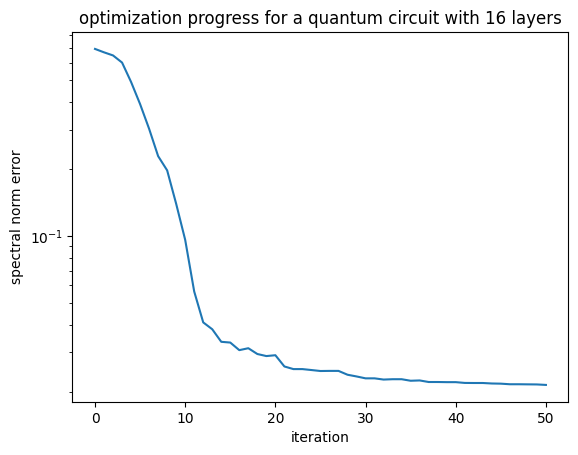

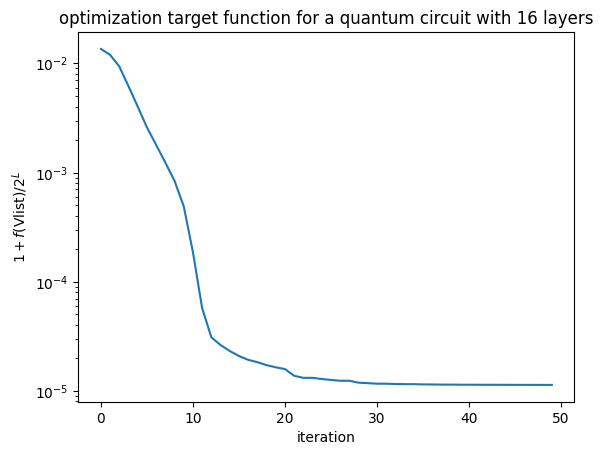

Last f:  -31.999638591864453


In [4]:
Vlist, f_iter, err_iter = dynamics_opt(hamil, t, eta, gamma, False, Vlist_start_ext, perms, penalty_weight=0, niter=50)

with h5py.File(f"./results/heisenberg1d_111_L{L}_t{t}_layers{nlayers}_gamma{gamma}_eta{eta}.hdf5", "w") as f:
    f.create_dataset("Vlist", data=Vlist)
    f.create_dataset("f_iter", data=f_iter)
    f.create_dataset("err_iter", data=err_iter)
    f.attrs["L"] = L
    f.attrs["t"] = float(t)

In [11]:
# Best Performing Setting I observed so far was (2, 5).

L = 4
t = 0.25
eta, gamma = (2, 5)
nlayers = eta*gamma+gamma+1
perms = [[i for i in range(L)] if i%2==0 else [i for i in range(1, L)]+[0] for i in range(nlayers)]

Vs = []
with h5py.File(f"./results/heisenberg1d_111_L{L}_t{t}_layers{nlayers}_gamma{gamma}_eta{eta}.hdf5", "r") as f:
    Vs = f["Vlist"][:]


L = 10
latt = qib.lattice.IntegerLattice((L,), pbc=True)
field = qib.field.Field(qib.field.ParticleType.QUBIT, latt)
hamil = qib.HeisenbergHamiltonian(field, J, h).as_matrix().toarray()
perms = [[i for i in range(L)] if i%2==0 else [i for i in range(1, L)]+[0] for i in range(nlayers)]
U = scipy.linalg.expm(-1j*hamil*t)
U_back = scipy.linalg.expm(1j*hamil*t)
print("Trotter error for same time, larger system: ", (np.linalg.norm(ansatz(reduce_list(Vs, gamma, eta), L, 
            reduce_list(perms, gamma, eta)) - U, ord=2)+np.linalg.norm(
        ansatz(Vs, L, perms) - U_back, ord=2))/2)

Trotter error for same time, larger system:  0.05030806768166928


In [12]:
t_total = 1
nsteps = 4
U_025 = ansatz(Vs, L, perms)
U_4_back = np.eye(2**L)
for i in range(nsteps):
    U_4_back = U_025 @ U_4_back
U_exact_back = scipy.linalg.expm(1j*hamil*t_total)

U_025 = ansatz(reduce_list(Vs, gamma, eta), L, reduce_list(perms, gamma, eta))
U_4 = np.eye(2**L)
for i in range(nsteps):
    U_4 = U_025 @ U_4
U_exact = scipy.linalg.expm(-1j*hamil*t_total)

cU_exact  = np.kron(rho_1_anc, U_exact_back) + np.kron(rho_0_anc, U_exact)
cU_approx = np.kron(rho_1_anc, U_4_back) + np.kron(rho_0_anc, U_4)
print(f"Trotter error for controlled version, repetition {nsteps}: ", np.linalg.norm(cU_exact - cU_approx, ord=2))

Trotter error for controlled version, repetition 4:  0.13883996116604852


In [34]:
"""
    Now the challenge is to turn the two qubit unitaries into their controlled 
    versions. For this, we employ a variational ansatz made up of 9 arbitrary
    unitaries acting on 3 qubits with different permutations. It is essential to
    reach a precision of around 1e-5 or lower in this optimization as these gates
    will be employed many times in the final controlled-time evolution circuit.
    This step brings an inevitable overhead to our compression protocol, as this 
    number '9' does not seem to be reducible in a trivial way.
"""


sys.path.append("../../src/controlled_unitary_optimizer")
from optimize_3q import optimize_3q 
from utils_3q import make_controlled, random_unitary

Xlists_opt = {}
perms_qc = [[0, 1], [0, 2], [1, 2], [0, 2], [0, 1], [1, 2], [0, 2], [0, 1], [1, 2]]

for i in range(0, nlayers, eta+1):
    cU = make_controlled(Vs[i])
    f_best, err_best, Glist_best = (0, 2, None)
    for _ in range(10):
        """
            It is possible to include single qubit gates in this optimization. You can use the 
            following commented out line as the starting point for that.
        """
        #Xlist_start = [random_unitary(2) for i in range(3*(len(perms_qc))+3)] + [random_unitary(4) for i in range(len(perms_qc))]
        Xlist_start = [random_unitary(4) for i in range(len(perms_qc))]
        Xlist, f_iter, err_iter = optimize_3q(L, cU, Xlist_start, perms_qc, niter=1000)
        if err_iter[-1] < err_best:
            f_best, err_best, Xlist_best = (f_iter[-1], err_iter[-1], Xlist)
    print("Best f: ", f_best)
    print("Best err: ", err_best)
    Xlists_opt[i] = Xlist_best

Best f:  -7.99420566729219
Best err:  0.05597894872083447
Best f:  -7.993970336955706
Best err:  0.062330048579135836
Best f:  -7.996808194345229
Best err:  0.04663227202073474
Best f:  -7.990345060690313
Best err:  0.07002283664910781
Best f:  -7.9796071550222605
Best err:  0.11210040528756134
Best f:  -7.997998427433275
Best err:  0.030998371144527578


In [14]:
# Save the optimal gates.

for i in range(0, nlayers, eta+1):
    with h5py.File(f"./results/heisenberg1d_111_L4_t{t}_layers{nlayers}_gamma{gamma}_eta{eta}_CUs_APPROXS_n{len(perms_qc)}_layer{i}.hdf5", "w") as file:
        file.create_dataset(f"Xlist_{i}", data=Xlists_opt[i])

In [50]:
Xlists_opt = {}
for i in range(0, nlayers, eta+1):
    with h5py.File(f"./results/heisenberg1d_111_L4_t{t}_layers{nlayers}_gamma{gamma}_eta{eta}_CUs_APPROXS_n{len(perms_qc)}_layer{i}.hdf5", "r") as file:
        Xlists_opt[i] = file[f"Xlist_{i}"][:]

In [100]:
"""
    Now here is to compare the performance of the ccU circuit
    with the 1st and 2nd order Trotter circuits, in terms of 
    gate count vs Trotter error. I demonstrate it on L=8 system.
"""

from qiskit import Aer, execute, transpile
from qiskit.circuit.library import CYGate, CZGate, IGate, CXGate
from qiskit.converters import circuit_to_dag
from qiskit.providers.aer.noise import NoiseModel, errors


def uncompr_trotterized_time_evolution(qc, hlocs, t, gate, lamb=None):
    # permutations specifying gate layout
    perms1 = [i for i in range(L)]
    perms2 = [i for i in range(1, L)]+[0]
    perm_set = [perms1, perms2]
    perms = perm_set
    
    K_layer = [None for _ in range(L)]
    for j in range(len(perms[0])//2):
        K_layer[perms[0][2*j]] = gate[0]
        K_layer[perms[0][2*j+1]] = gate[1]
        
    K_b = [K_layer, None]
    K_a = [None, K_layer]
    
    Vlists = [[scipy.linalg.expm(-1j*t*hloc) for i in range(len(perm_set))] for hloc in hlocs]
    Vlists_gates = [[] for _ in hlocs]
    for i, Vlist in enumerate(Vlists):
        for V in Vlist:
            qc2 = qiskit.QuantumCircuit(2)
            qc2.unitary(V, [0, 1], label='str')
            Vlists_gates[i].append(qc2)


    for layer in range(len(perms)):
        if K_b[layer] is not None:
            qc.x(L)
            for j in range(L):
                if K_b[layer][j] is not None:
                    qc.append(K_b[layer][j](), [L, L-1-j])
            qc.x(L)

            
        for Vlist_gates in Vlists_gates:
            qc_gate = Vlist_gates[layer]
            
            for j in range(len(perms[layer])//2):
                    qc.append(qc_gate.to_gate(), [L-(perms[layer][2*j]+1), 
                                                    L-(perms[layer][2*j+1]+1)])

        if K_a[layer] is not None:
            qc.x(L)
            for j in range(L):
                if K_a[layer][j] is not None:
                    qc.append(K_a[layer][j](), [L, L-1-j])
            qc.x(L)


def uncompr_controlled_trotter(c1, c2, L, J, h=(0,0,0), dagger=False, nsteps=1, trotter_degree=2):
    if c1/(2*nsteps) > 0.075:
        nsteps = int(np.ceil(c1/(2 * 0.075)))
    dt = c1/(2*nsteps)
    t = c1/2
    
    hloc1 = construct_heisenberg_local_term((J[0], 0   ,    0), (0, h[1], 0))
    hloc2 = construct_heisenberg_local_term((0   , J[1],    0), (0, 0, h[2]))
    hloc3 = construct_heisenberg_local_term((0   , 0   , J[2]), (h[0], 0, 0))
    qc_cU_ins = qiskit.QuantumCircuit(L+1)

    if dagger:
        qc_cU_ins.x(L)

    hs = ((hloc1, ), (hloc2, ), (hloc3, ))
    cgates = ((CXGate, CZGate), (CXGate, CYGate), (CZGate, CYGate))

    # Trotter 2nd Order.
    indices = [0, 1, 2, 1, 0]
    coeffs  = [0.5, 0.5, 1, 0.5, 0.5]
    if trotter_degree==1:
        # Trotter 1st Order.
        indices = [0, 1, 2]
        coeffs  = [1, 1, 1]
    if trotter_degree==3:
        # Trotter 3rd Order.
        indices = [0, 1, 2, 1, 0, 1, 2, 1, 0]
        coeffs  = [0.25, 0.25, 0.5, 0.25, 0.5, 0.25, 0.5, 0.25, 0.25]
        
    for n in range(nsteps):
        for index, coef in zip(indices, coeffs):
            uncompr_trotterized_time_evolution(qc_cU_ins, hs[index], dt * coef, cgates[index])

    qc_cU_ins.cp(-c2, L,  0)
    qc_cU_ins.x(0)
    qc_cU_ins.cp(-c2, L, 0)
    qc_cU_ins.x(0)

    if dagger:
        qc_cU_ins.x(L)

    return qc_cU_ins
    
L = 10
latt = qib.lattice.IntegerLattice((L,), pbc=True)
field = qib.field.Field(qib.field.ParticleType.QUBIT, latt)
perms = [[i for i in range(L)] if i%2==0 else [i for i in range(1, L)]+[0] for i in range(nlayers)]
hamil = qib.HeisenbergHamiltonian(field, J, h).as_matrix().toarray()


trotter4_cxs= []
#trotter3_errs = []
for t in [.25, .5, 1, 2, 4, 8]:
    U = scipy.linalg.expm(-1j * t * hamil)
    cU = np.kron(rho_0_anc, U.conj().T) + np.kron(rho_1_anc, U)
    
    qc = uncompr_controlled_trotter(2*t, 0, L, J, h, trotter_degree=3)
    backend = Aer.get_backend("unitary_simulator")
    qc_unit = execute(transpile(qc), backend).result().get_unitary(qc, L+1).data

    noise_model = NoiseModel()
    dag = circuit_to_dag(transpile(qc, basis_gates=noise_model.basis_gates+['unitary', 'initialize']))
    count_ops = dag.count_ops()

    trotter4_cxs.append(count_ops['cx']+count_ops['unitary'])
    #trotter3_errs.append(np.linalg.norm(qc_unit - cU, ord=2))

    print(f"t={t}, Gate Count: ", count_ops['cx']+count_ops['unitary'], " Trotter error: ", np.linalg.norm(qc_unit - cU, ord=2))

/tmp/ipykernel_33049/4251381353.py:119: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  qc_unit = execute(transpile(qc), backend).result().get_unitary(qc, L+1).data


t=0.25, Gate Count:  1080  Trotter error:  0.06725631224708734
t=0.5, Gate Count:  1890  Trotter error:  0.14205102742731254
t=1, Gate Count:  3780  Trotter error:  0.22850365827138486
t=2, Gate Count:  7290  Trotter error:  0.3628332340103134
t=4, Gate Count:  14580  Trotter error:  0.544019093110164
t=8, Gate Count:  28890  Trotter error:  0.9982583848986343


In [101]:
from qiskit import Aer, execute, transpile

qc = qiskit.QuantumCircuit(L+1)
qc.x(L)
for i, V in enumerate(Vs):
    layer = i
    if i in range(0, nlayers, eta+1):
        Glist = Xlists_opt[i]
        qc_3 = qiskit.QuantumCircuit(3)
        for j, G in enumerate(Glist):
            qc_3.unitary( G, (3-1-perms_qc[j][1], 3-1-perms_qc[j][0]))

        for j in range(L//2):
            qc.append(qc_3.to_gate(), [L-perms[layer][2*j]-1, L-perms[layer][2*j+1]-1, L])
        
    else:
        for j in range(L//2):
            qc.unitary(V, [L-perms[layer][2*j]-1, L-perms[layer][2*j+1]-1])
qc.x(L)


ccU_cxs= []
ccU_errs = []
for t in [0.25, .5, 1, 2, 4, 8]:
    qc_ext = qiskit.QuantumCircuit(L+1)
    for i in range(int(t/0.25)):
        qc_ext.append(qc.to_gate(), [i for i in range(L+1)])
    
    perms = [[i for i in range(L)] if i%2==0 else [i for i in range(1, L)]+[0] for i in range(nlayers)]
    U = scipy.linalg.expm(-1j * t * hamil)
    cU = np.kron(rho_0_anc, U.conj().T) + np.kron(rho_1_anc, U)
    backend = Aer.get_backend("unitary_simulator")
    qc_unit = execute(transpile(qc_ext), backend).result().get_unitary(qc_ext, L+1).data
    noise_model = NoiseModel()
    dag = circuit_to_dag(transpile(qc_ext, basis_gates=noise_model.basis_gates+['unitary', 'initialize', 'cx']))
    count_ops = dag.count_ops()

    ccU_errs.append(np.linalg.norm(qc_unit - cU, ord=2))
    print(f"t={t}, Gate Count: ", count_ops['unitary'], " Trotter error: ", np.linalg.norm(qc_unit - cU, ord=2))

/tmp/ipykernel_33049/167402591.py:33: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  qc_unit = execute(transpile(qc_ext), backend).result().get_unitary(qc_ext, L+1).data


t=0.25, Gate Count:  320  Trotter error:  0.07297661192752307
t=0.5, Gate Count:  640  Trotter error:  0.10488838896582746
t=1, Gate Count:  1280  Trotter error:  0.13884127578118075
t=2, Gate Count:  2560  Trotter error:  0.1930845063661609
t=4, Gate Count:  5120  Trotter error:  0.29477011551691357
t=8, Gate Count:  10240  Trotter error:  0.5381282197699179


Text(0, 0.5, 'Trotter Error')

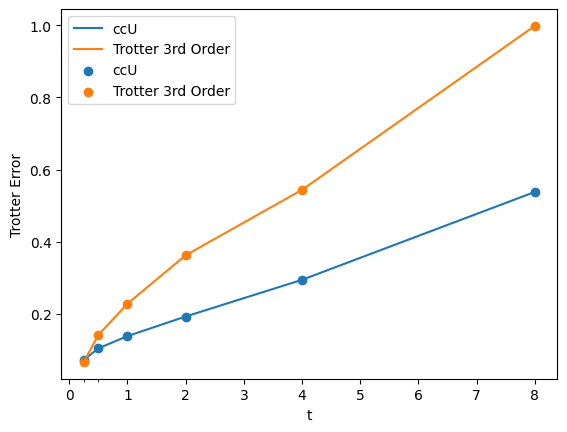

In [122]:
plt.plot([0.25, .5, 1, 2, 4, 8], ccU_errs, label="ccU")
plt.plot([0.25, .5, 1, 2, 4, 8], [0.06725631224708734, 0.14205102742731254, 0.22850365827138486, 0.3628332340103134, 0.544019093110164,  0.9982583848986343], label="Trotter 3rd Order")

plt.scatter([0.25, .5, 1, 2, 4, 8], ccU_errs, label="ccU")
plt.scatter([0.25, .5, 1, 2, 4, 8], [0.06725631224708734, 0.14205102742731254, 0.22850365827138486, 0.3628332340103134, 0.544019093110164,  0.9982583848986343], label="Trotter 3rd Order")

plt.xticks([0.25, .5, 1, 2, 4, 8], minor=True)

plt.legend()
plt.xlabel("t")
plt.ylabel("Trotter Error")

In [ ]:
plt.plot([0.25, .5, 1, 2, 4, 8], [ 320, 640, 1280, 2560, 5120, 10240], label="ccU", ls='--')
plt.plot([0.25, .5, 1, 2, 4, 8], trotter4_cxs, label="Trotter 3rd Order", ls='--')

plt.scatter([0.25, .5, 1, 2, 4, 8], [ 320, 640, 1280, 2560, 5120, 10240], label="ccU")
plt.scatter([0.25, .5, 1, 2, 4, 8], trotter4_cxs, label="Trotter 3rd Order")

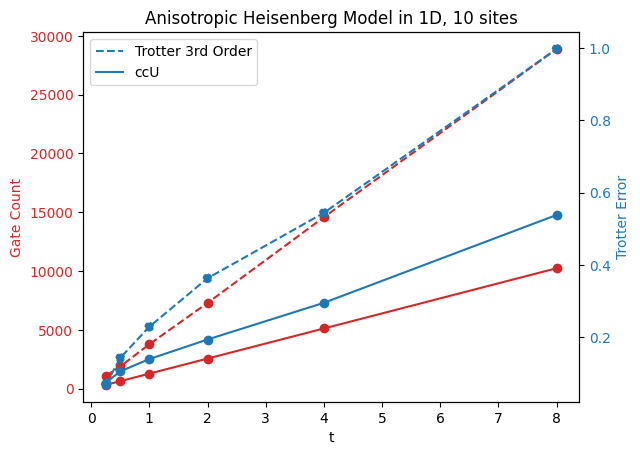

In [129]:
ts = [0.25, .5, 1, 2, 4, 8]
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('t')
ax1.set_ylabel('Gate Count', color=color)
ax1.plot(ts, [ 320, 640, 1280, 2560, 5120, 10240], label="ccU", color=color)
ax1.plot(ts, trotter4_cxs, label="Trotter 3rd Order", ls='--', color=color)
ax1.scatter(ts, [ 320, 640, 1280, 2560, 5120, 10240], color=color)
ax1.scatter(ts, trotter4_cxs, color=color)
ax1.tick_params(axis='y', labelcolor=color)


ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Trotter Error', color=color)  # we already handled the x-label with ax1
ax2.plot(ts,  [0.06725631224708734, 0.14205102742731254, 0.22850365827138486, 0.3628332340103134, 0.544019093110164,  0.9982583848986343], ls='--', label="Trotter 3rd Order", color=color)
ax2.plot(ts, ccU_errs, color=color, label="ccU")

ax2.scatter(ts,  [0.06725631224708734, 0.14205102742731254, 0.22850365827138486, 0.3628332340103134, 0.544019093110164,  0.9982583848986343], ls='--', color=color)
ax2.scatter(ts, ccU_errs, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.legend()
plt.title("Anisotropic Heisenberg Model in 1D, 10 sites")
plt.savefig('./figs/heisenberg1d_111_trotter_and_cxs.png', dpi=300)
plt.show()